<a href="https://colab.research.google.com/github/JINDOT/Data_Analysis_/blob/main/%231_Online_Retail/RFM_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means를 이용한 Clustering

## CRM 마케팅

CRM 마케팅에서 고객을 분류할 때 쓰이는 방법은 **세분화**와 **군집화**가 있다.

> 세분화(Segmentation)

유사성을 기반으로 고객들을 여러 그룹으로 각기 수동으로 배치하는 것이다.

대표적으로 인구통계학적 분류(나이/성별/주소 등)과 고객 등급에 따라 고객을 분류하는 방법이다.

이와 같은 방법은 **마케터가 설정한 기준이 있기 때문에 비통계적 방법**이다. 또한 직관과 짐작에 의존하므로 원하는 결과가 도출하지 못하거나 오류가 발생할 수 있다.

> 군집화(Clustering)

고객을 그룹으로 묶을 수 있도록 그들의 유사성들을 찾아내는 자동화된 통계적으로 엄격한 프로세스이다.

타겟 고객을 사전에 알고 있는 것이 아니라 누구를 타겟 고객으로 삼을 것인가 를 발견하는 것으로 **고객의 여러 요소를 사용하여 고객기반 속에 존재하는 세그먼트들을 자동으로 발견하는 방법**이다.

대표적으로 K-Means(평균), 아프리오리 알고리즘이 있다.

## K-means ?

K-평균 알고리즘. 주어진 데이터를 k개의 클러스터로 묶는 알고리즘으로(=means(평균을) n개의 k(클러스터)로 묶는다.), 각 클러스터와 거리 차이의 분산을 최소화하는 방식으로 작동한다.

분할법에 속하며 주어진 데이터를 여러 파티션(그룹)으로 나누는 방식이다.

> 알고리즘 작동 원리
* 군집의 개수(클러스터 수) 설정
* 초기 중심점 설정
* 데이터를 군집에 할당
* 중심점 재설정
* 데이터를 군집에 재할



## 필요 라이브러리 불러오기

In [ ]:
# Korean
# !pip install koreanize-matplotlib

In [ ]:
# 군집화 시각화
# !conda install -c districdatalabs yellowbrick
# !pip install yellowbrick

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import koreanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

## 데이터프레임 기초작업

In [ ]:
# rfm 확인
pd.read_csv('/content/drive/MyDrive/csv/rfm.csv')

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
0,12346.0,326,1,77183.60,1,1,5,115,7,silver
1,12347.0,2,182,4310.00,5,5,5,555,15,platinum
2,12348.0,75,31,1797.24,2,3,4,234,9,gold
3,12349.0,19,73,1757.55,4,4,4,444,12,platinum
4,12350.0,310,17,334.40,1,2,2,122,5,silver
...,...,...,...,...,...,...,...,...,...,...
4333,18280.0,278,10,180.60,1,1,1,111,3,silver
4334,18281.0,181,7,80.82,1,1,1,111,3,silver
4335,18282.0,8,12,178.05,5,1,1,511,7,silver
4336,18283.0,4,721,2045.53,5,5,4,554,14,platinum


In [ ]:
# CustomerID 값을 Index로 지정
rfm = pd.read_csv('/content/drive/MyDrive/csv/rfm.csv', index_col='CustomerID')
rfm.shape

(4338, 9)

In [ ]:
# 클러스터
# Recency, Frequency, MonetaryValue만 따로 rfm_cluster 변수에 담아 사용
# rfm[['Recency', 'Frequency', 'MonetaryValue']]
rfm_cluster = rfm.iloc[:,:3]
rfm_cluster.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


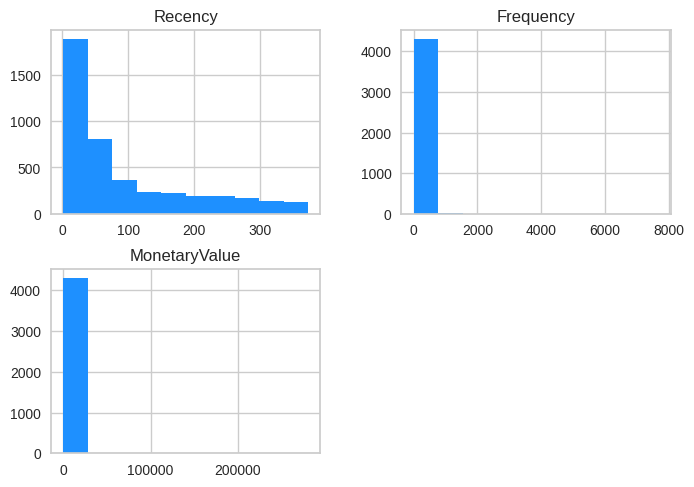

In [ ]:
rfm_cluster.hist(color='dodgerblue');

역시나 이상치가 존재한다(그래프가 한 쪽으로 치우쳐짐)

### 로그변환
* 머신러닝 모델이 잘 이해할 수 있도록 정규분포 형태로 변환
* rfm_cluster_log = np.log(rfm_cluster + 1) = log1p
* 로그 함수는 입력값이 0일 경우 정의되지 않는다 = 0을 포함한 모든 값에 로그를 취함
* 작은 값에 대한 변동을 더 잘 반영 = RFM x값이 1보다 클 때 급격히 증가하지만 x 값이 1보다 작을 때 천천히 증다한다
* 작은 값을 더 균형 있게 다룰 수 있음

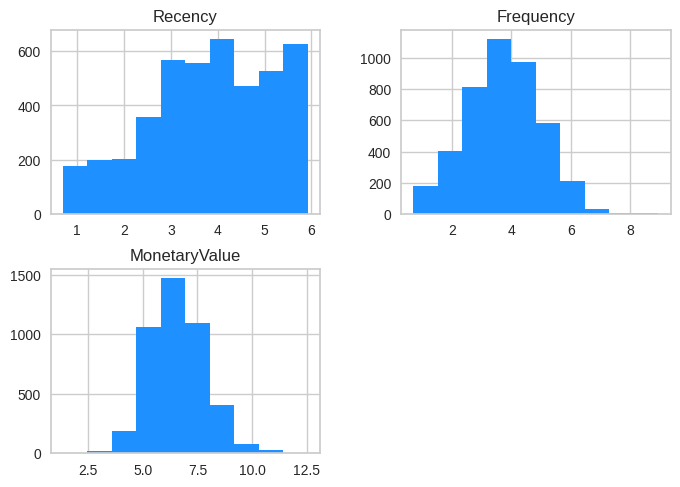

In [ ]:
rfm_cluster_log = np.log1p(rfm_cluster)
rfm_cluster_log.hist(color='dodgerblue');

### 스케일 조정(Scaling)

* StandardScaler : 평균 0, 분산 1로 조정
* MinMaxScaler : 모든 값을 0 ~ 1 사이에 조정
* RobustScaler : 평균과 분산 대신 중간값과 사분위값 사용

모든 알고리즘에 적용한다고 무조건적으로 좋아지진 않지만 회귀, KNN, K-Means 등 거리기반 알고리즘에 사용하면 나은 성능을 보인다.

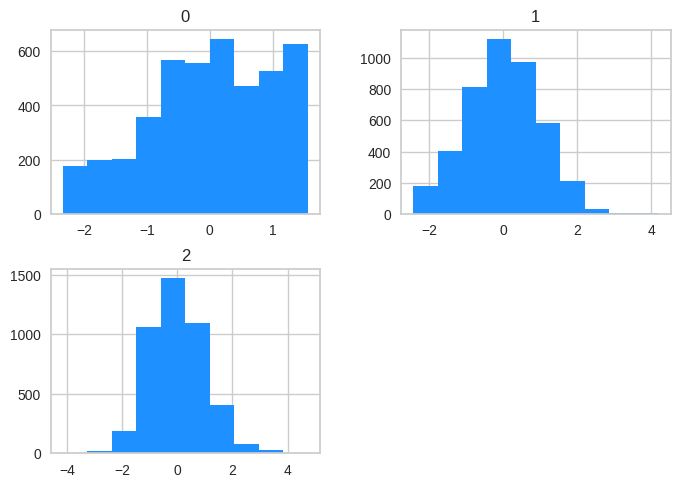

In [ ]:
ss = StandardScaler()
X = ss.fit_transform(rfm_cluster_log)

pd.DataFrame(X).hist(color='dodgerblue');

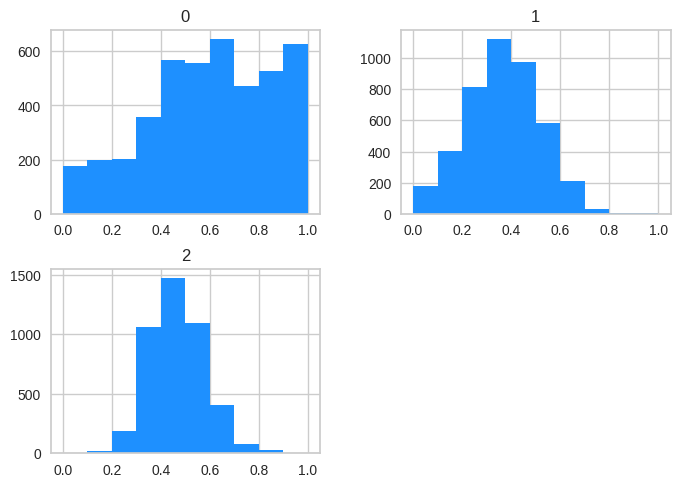

In [ ]:
s = MinMaxScaler()
X = s.fit_transform(rfm_cluster_log)
pd.DataFrame(X).hist(color='dodgerblue');

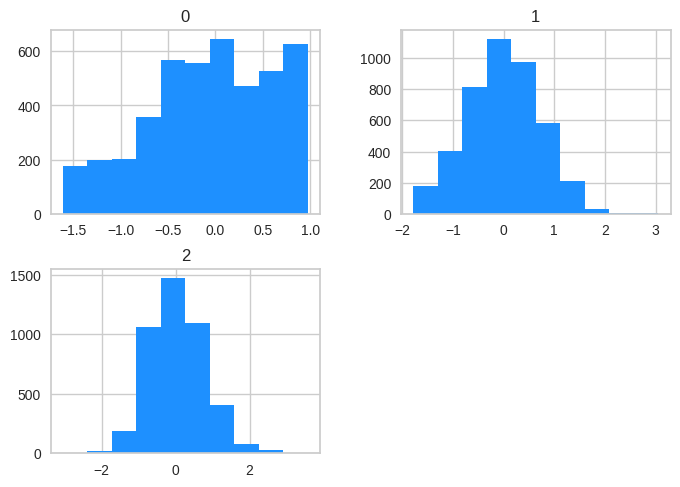

In [ ]:
r = RobustScaler()
X = r.fit_transform(rfm_cluster_log)
pd.DataFrame(X).hist(color='dodgerblue');

## StandardScaler 를 이용한 K-means
* 고객 세그먼트를 머신러닝의 비지도학습 중 하나인 K-means를 통해 군집화할 예정
> 고객ID 기준 RFM 데이터셋 로드
> RFM 값만 따로 분리
> 로그를 적용해서 정규화(정규분포 형태로 변환)
> StandardScaler 를 통해 평균이 0, 표준편차가 1이 되게 변환

* fit() : 학습(StandardScaler 라면 주어진 데이터의 평균, 표준편차 등을 학습)
* transform() : 비지도학습에서 변환
* fit_transform() : 학습과 변환을 한번에 함.
* predict() : 지도학습의 분류, 회귀 등의 예측

In [ ]:
# z = (x - u) / std
ss = StandardScaler()
X = ss.fit_transform(rfm_cluster_log)
X = pd.DataFrame(X, columns = rfm_cluster_log.columns)
X.head()

,Recency,Frequency,MonetaryValue
0,1.461907,-2.437889,3.710308
1,-2.040527,1.188913,1.417102
2,0.372488,-0.211389,0.722104
3,-0.624188,0.461823,0.704363
4,1.424454,-0.673430,-0.612664


### K-Means
* 샘플을 n개의 등분산 그룹으로 분리하여 **관성 또는 클러스터 내 제곱합 이라는 기준을 최소화함**으로써 데이터를 클러스터링
* 클러스터 수를 지정해야함


In [ ]:
# cluster.KMeans, metrics.silhouette_score 불러오기
# rfm_norm 값을 학습하고 elbow 값을 보기위해 inertia_ 값을 리스트로 생성
# silhouette_score(X, kmeans.labels_) 값도 리스트로 생성

# KMeans(
#     n_clusters=8,
#     *,
#     init='k-means++',
#     n_init="auto",
#     max_iter=300,
#     tol=0.0001,
#     verbose=0,
#     random_state=None,
#     copy_x=True,
#     algorithm='lloyd',
# )

# n_cluster : 몇 개의 클러스터로 나눌 것인가
# n_init : 클러스터 중심을 초기화하는 과정을 여러 번 반복하는 횟수를 얼마나 할 것인가
# random_state : 난수 생성에 사용되는 시드 값
kmeans = KMeans(n_clusters=8, n_init='auto', random_state=42)
kmeans.fit(X)

# cluster_centers_ : 각 클러스터의 중심 좌표를 나타내는 배열
# inertia_ : 군집 내 관성, 각 데이터 포인트가 가장 가까운 클러스터 중심까지의 거리 제곱 합
kmeans.cluster_centers_, kmeans.inertia_

(array([[-0.36897607, -0.66984552, -0.80897528],
        [ 0.42384092,  0.20266805,  0.10666179],
        [-1.50089666,  1.58646594,  1.71175944],
        [-0.12920724,  0.99451208,  0.98845587],
        [ 1.14140717, -0.49988931, -0.68458615],
        [-1.19169688,  0.38878091,  0.27673355],
        [ 1.00027544, -1.59759399, -1.48142454],
        [ 0.51375114, -1.3675099 ,  0.25709927]]),
 2784.2214944949033)

In [ ]:
kmeans.cluster_centers_.shape

(8, 3)

### Within-Cluster Sum of Square 값으로 군집 수 찾기

In [ ]:
inertia = []
silhouettes = []
range_n_clusters = range(2, 21)
# for k in range(2, 11):
#   kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
#   kmeans.fit(X)
#   inertia.append(kmeans.inertia_)

for n_cluster in range_n_clusters:
  kmeans = KMeans(n_clusters=n_cluster, n_init='auto', random_state=42)
  kmeans.fit(X)
  inertia.append(kmeans.inertia_)
  silhouettes.append(silhouette_score(X, kmeans.labels_))
  print(n_cluster, kmeans.inertia_, silhouette_score(X, kmeans.labels_))

2 6774.630598792502 0.39913744305424737
3 5237.381831387408 0.3031987778341889
4 4302.427207041834 0.30911798563015114
5 3768.0246248787344 0.28099347936783897
6 3261.086095275929 0.2732133190288724
7 2959.8927672031186 0.2642562705511515
8 2784.2214944949033 0.2719135595057687
9 2562.349226005813 0.2644121297482516
10 2397.5089364796586 0.2616478036276676
11 2223.309533357242 0.26788234697475055
12 2135.9063683466998 0.2586495153405718
13 2052.121430160424 0.25556212526841976
14 1959.8761084895887 0.25238962537854437
15 1838.6093450833343 0.25353699696895593
16 1762.0002151317015 0.2497255606748054
17 1725.5614433164565 0.23983330417392593
18 1678.1053454588512 0.23748132739691075
19 1624.589051245031 0.241561575957974
20 1551.4309520275453 0.24669046925512264


### Elbow of Method
* Number clusters
* Within-Cluster Sum of Square

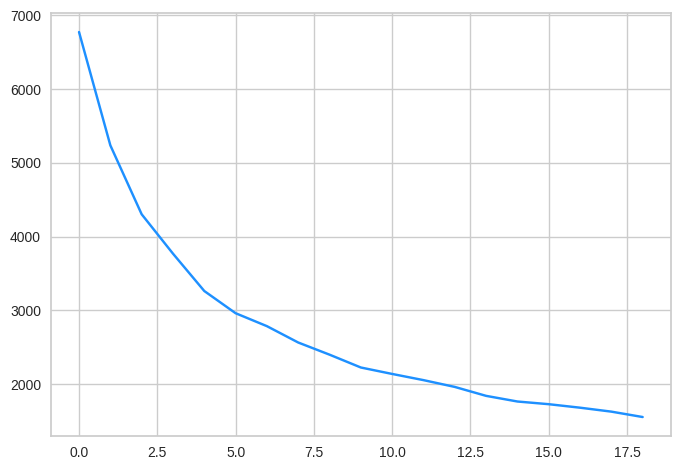

In [ ]:
# inertia 값이 작으면 좋다.
pd.Series(inertia).plot(kind='line', color='dodgerblue');

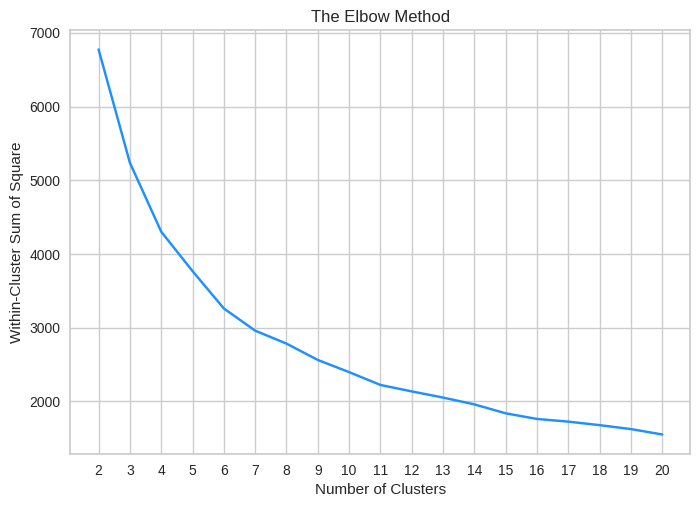

In [ ]:
plt.plot(range_n_clusters, inertia, color='dodgerblue')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Square')
plt.xticks(range_n_clusters)
plt.show()

* Cluster 값이 클수록 Square 값이 작아진다.

### Silhouette Score

* 실루엣 계수는 클러스터링의 성능을 평가하기 위한 지표 중 하나
* 각 데이터 포인트의 실루엣 계수는 해당 데이터 포인트가 얼마나 잘 군집화 되었는지를 나타낸다.
* 정답 레이블을 모르는 경우 모델 자체를 사용하여 평가

> 좋은 군집화의 조건
* 전체 실루엣 계수의 평균값은 -1 ~ 1 사이이고 1에 가까울 수록 좋다.
* -1 > 해당 데이터 포인트가 잘못된 클러스터에 할당
* 1 > 해당 데이터 포인드가 다른 클러스터와 잘 분리됨



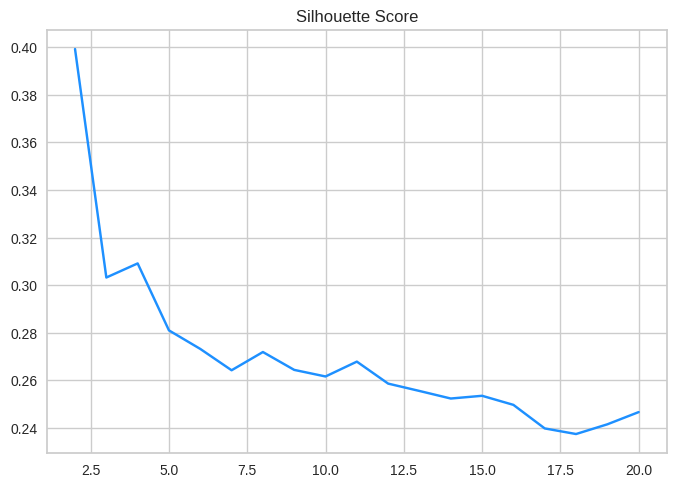

In [ ]:
plt.title('Silhouette Score')
plt.plot(range_n_clusters, silhouettes, color='dodgerblue')
plt.show()

* 실루엣 점수가 감소하는 경향을 가지고 있고, 특정 K 값에서 점수의 급겨한 감소가 발생한 지점이 있다.
* 클러스터 수가 너무 많거나 적어서 적절한 군집을 형성하지 못했다.

* 2개 ~ 4개 사이가 그나마 나은..

### KElbow Visualizer

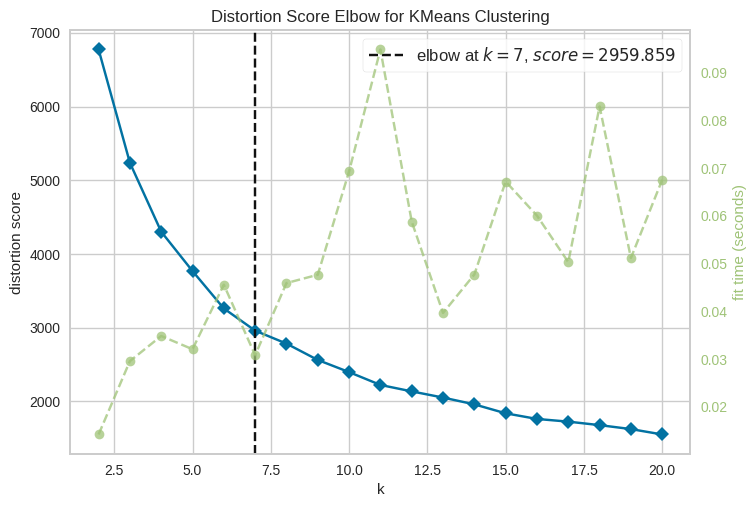

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
KEV = KElbowVisualizer(kmeans, k=20, n_init='auto')
KEV.fit(X)
KEV.show()

* 그래프 상으로 7개를 최적의 클러스터 수로 제안하고 있다.

### finalize n_cluster

In [ ]:
# 위의 그래프에서는 최적의 클러스터 수를 7개로 했으나!
# RFM 분석을 통해서 3개를 나누었던 적이 있기 때문에 k=3 으로 지정
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, n_init='auto',random_state=42)
kmeans.fit(X)

KMeans(n_clusters=3, n_init='auto', random_state=42)

In [ ]:
kmeans.labels_

array([1, 2, 1, ..., 1, 2, 1], dtype=int32)

In [ ]:
kmeans.cluster_centers_

array([[ 0.79690802, -0.97740351, -0.91891438],
       [-0.0424308 ,  0.14386538,  0.07979015],
       [-1.09758989,  1.17899544,  1.20943507]])

In [ ]:
pd.Series(kmeans.labels_).value_counts()

,count
1,1838
0,1496
2,1004


### 실루엣 분석 시각화

In [ ]:
silhouette_avg = silhouette_score(X, kmeans.labels_)
silhouette_avg

0.3031987778341889

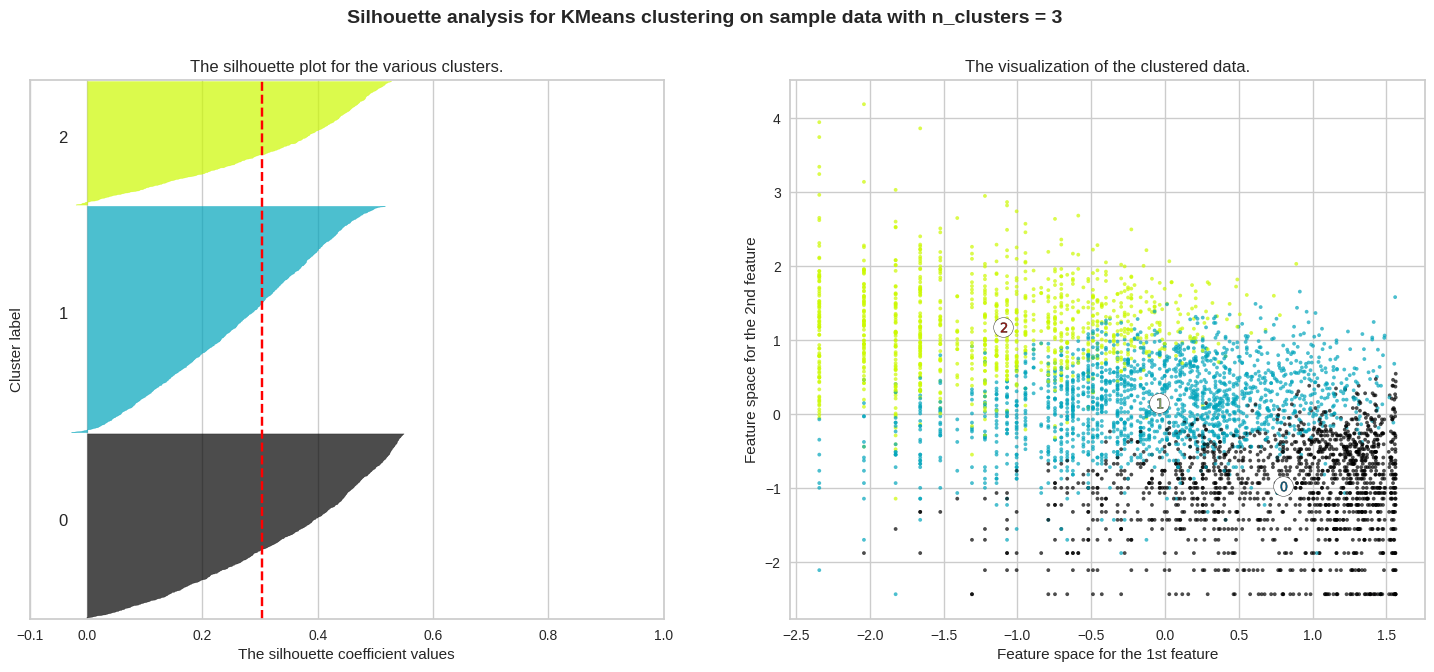

In [ ]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

cluster_labels = kmeans.labels_
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()

### RFM_class 와 군집결과 교차표

In [ ]:
rfm['Cluster'] = kmeans.labels_
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
CustomerID,,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7,silver,1
12347.0,2,182,4310.00,5,5,5,555,15,platinum,2
12348.0,75,31,1797.24,2,3,4,234,9,gold,1
12349.0,19,73,1757.55,4,4,4,444,12,platinum,1
12350.0,310,17,334.40,1,2,2,122,5,silver,0
...,...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,3,silver,0
18281.0,181,7,80.82,1,1,1,111,3,silver,0
18282.0,8,12,178.05,5,1,1,511,7,silver,1


In [ ]:
pd.crosstab(rfm['RFM_class'], rfm['Cluster'])

Cluster,0,1,2
RFM_class,,,
gold,15,1374,20
platinum,0,277,984
silver,1481,187,0


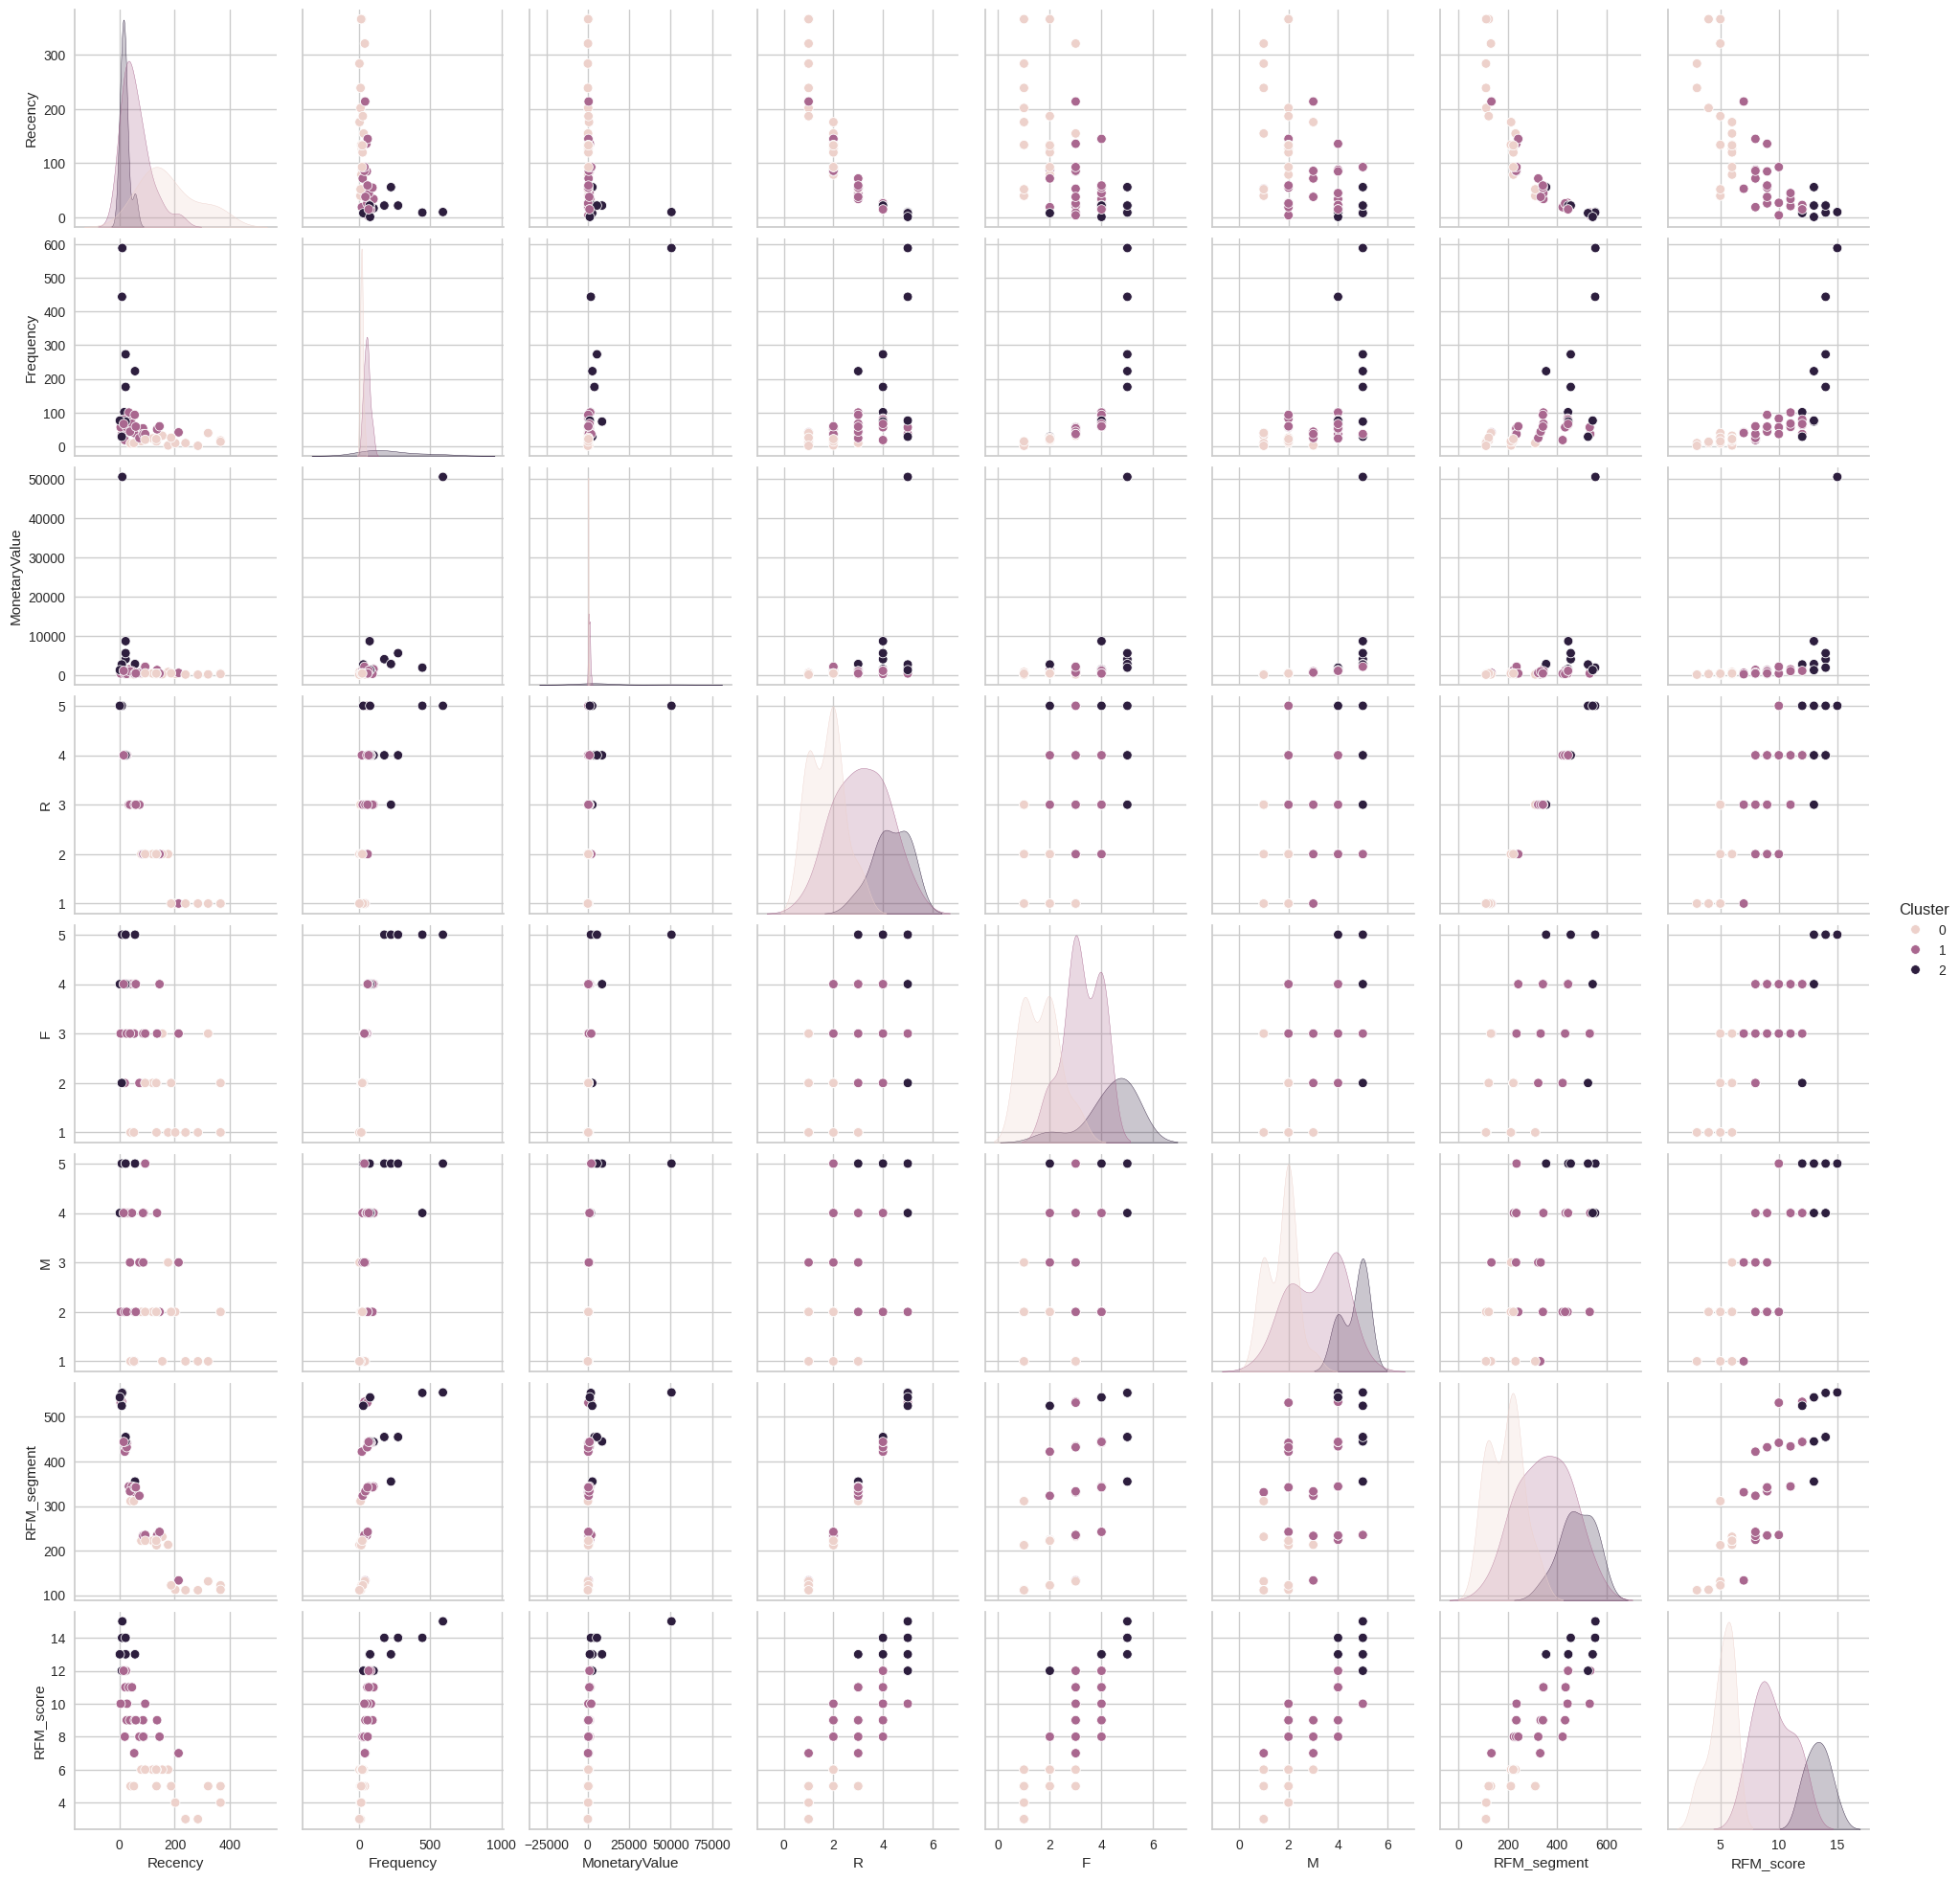

In [ ]:
# pairplot
sns.pairplot(data=rfm.sample(50), hue='Cluster')

### What if

In [ ]:
# What if
# 앞서 확인한 최적의 클러스터 수 7개로 가져갔다면?
# 고객군을 좀 더 상세히 7군으로 나누었다?
# 예상으로는 silver 1,2,3 gold 1,2 platinum 1,2
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, n_init='auto',random_state=42)
kmeans.fit(X)

KMeans(n_clusters=7, n_init='auto', random_state=42)

In [ ]:
kmeans.labels_

array([1, 5, 1, ..., 0, 5, 4], dtype=int32)

In [ ]:
kmeans.cluster_centers_

array([[-0.39471323, -0.77020767, -0.80222248],
       [ 0.3489757 ,  0.13351489,  0.10293347],
       [-1.21600722,  0.39174939,  0.28998917],
       [ 1.10031391, -0.51639463, -0.5562629 ],
       [-0.08385408,  0.9731744 ,  0.97201109],
       [-1.47689493,  1.58370131,  1.69621991],
       [ 1.02750456, -1.55527327, -1.35371718]])

In [ ]:
pd.Series(kmeans.labels_).value_counts()

,count
1,881
3,759
4,614
0,612
2,606
6,466
5,400


In [ ]:
silhouette_avg = silhouette_score(X, kmeans.labels_)
silhouette_avg

# 점수가 높아야 좋음.

0.2642562705511515

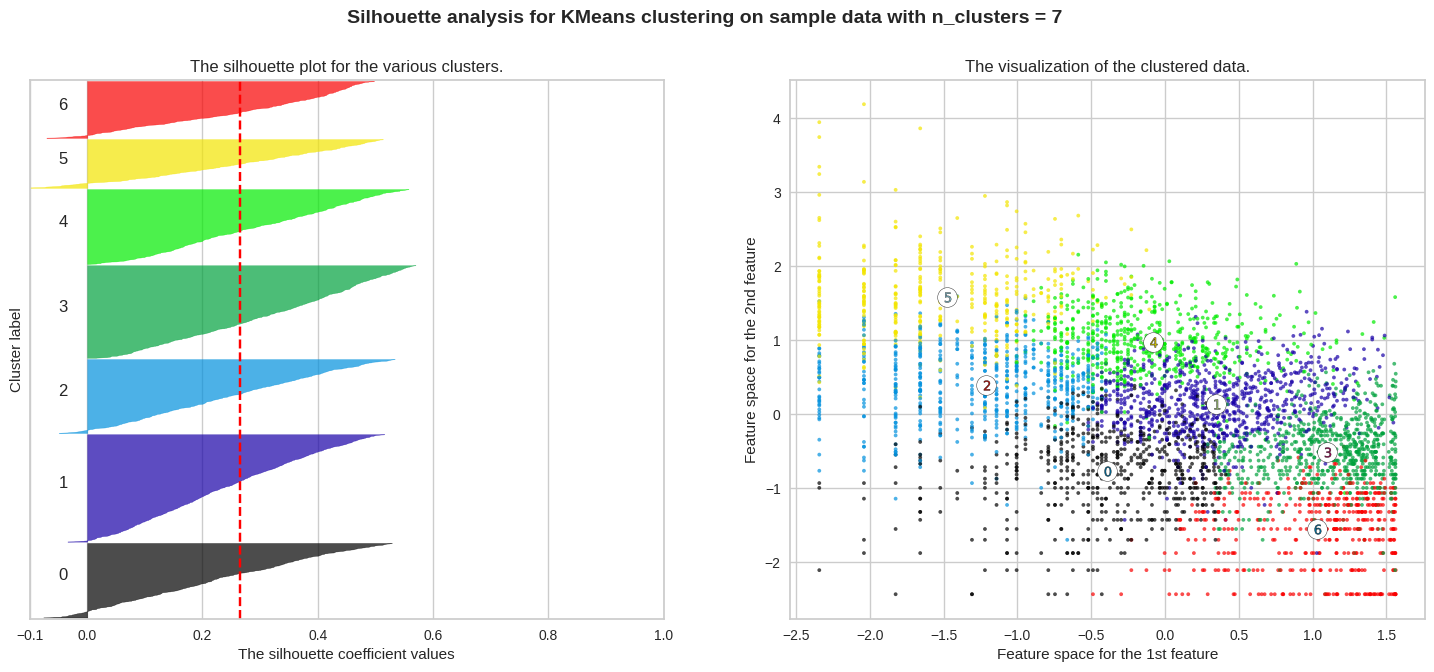

In [ ]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

cluster_labels = kmeans.labels_
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()

In [ ]:
rfm['Cluster_7'] = kmeans.labels_
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster,Cluster_7
CustomerID,,,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7,silver,1,1
12347.0,2,182,4310.00,5,5,5,555,15,platinum,2,5
12348.0,75,31,1797.24,2,3,4,234,9,gold,1,1
12349.0,19,73,1757.55,4,4,4,444,12,platinum,1,2
12350.0,310,17,334.40,1,2,2,122,5,silver,0,3
...,...,...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,3,silver,0,6
18281.0,181,7,80.82,1,1,1,111,3,silver,0,6
18282.0,8,12,178.05,5,1,1,511,7,silver,1,0


In [ ]:
pd.crosstab(rfm['RFM_class'], rfm['Cluster_7'])

Cluster_7,0,1,2,3,4,5,6
RFM_class,,,,,,,
gold,229,788,238,18,136,0,0
platinum,0,16,368,0,477,400,0
silver,383,77,0,741,1,0,466


망했다. k = 7 개에서 가장 최적화라 시도해보았지만 평균 실루엣 계수가 0.25로 매우 불안정하다.

좋은 클러스터링의 조건
- 전체 실루엣 계수의 평균값, 즉 사이킷런의 silhouette_score() 값은 0~1사이의 값을 가지며, **1에 가까울수록 좋다**.

- 하지만 **전체 실루엣 계수의 평균값과 더불어 개별 군집의 평균값의 편차가 크지 않아야 한다.** 즉, 개별 군집의 실루엣 계수 평균값이 전체 실루엣 계수의 평균값에서 크게 벗어나지 않는 것이 중요하다. 만약 전체 실루엣 계수의 평균값은 높지만, 특정 군집의 실루엣 계수 평균값만 유난히 높고 다른 군집들의 실루엣 계수 평균값은 낮으면 좋은 군집화 조건이 아니다.

> 2개가 가장 잘나왔다..

### 도르마무..

Overall average silhouette score: 0.26506452356718846
Cluster 0 average silhouette score: 0.295090432154362
Cluster 1 average silhouette score: 0.33860888780504556
Cluster 2 average silhouette score: 0.21789004706628223
Cluster 3 average silhouette score: 0.255238858264041
Cluster 4 average silhouette score: 0.2520934812114499
Cluster 5 average silhouette score: 0.23987176340639288
Cluster 6 average silhouette score: 0.24684322567594846
Standard deviation of silhouette scores across clusters: 0.037327662060423275


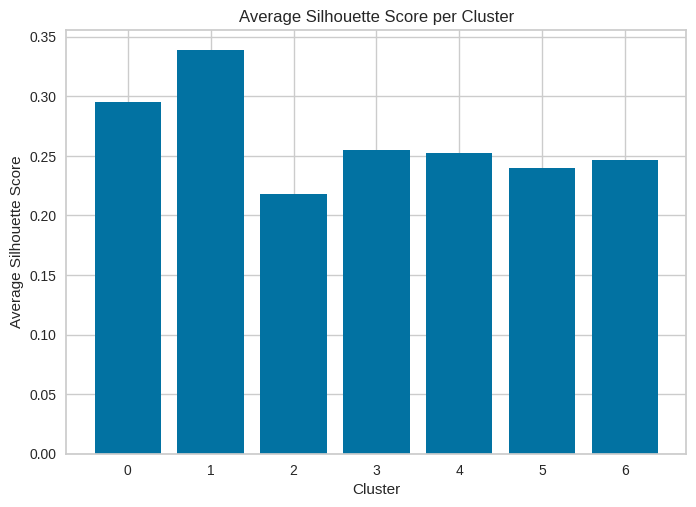

In [ ]:
# # 개별 군집 평균값과 전체 실루엣 계수 평균값 비교

# # 클러스터 개수 설정
# n_clusters = 7

# # KMeans 클러스터링
# kmeans = KMeans(n_clusters=n_clusters, random_state=10)
# cluster_labels = kmeans.fit_predict(X)

# # 전체 실루엣 계수의 평균값 계산
# silhouette_avg = silhouette_score(X, cluster_labels)
# print(f"Overall average silhouette score: {silhouette_avg}")

# # 개별 데이터 포인트의 실루엣 계수 계산
# sample_silhouette_values = silhouette_samples(X, cluster_labels)

# # 각 클러스터의 평균 실루엣 계수 계산
# silhouette_per_cluster = []
# for i in range(n_clusters):
#     cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#     cluster_avg = np.mean(cluster_silhouette_values)
#     silhouette_per_cluster.append(cluster_avg)
#     print(f"Cluster {i} average silhouette score: {cluster_avg}")

# # 클러스터 간 평균 실루엣 계수의 편차 계산
# silhouette_std = np.std(silhouette_per_cluster)
# print(f"Standard deviation of silhouette scores across clusters: {silhouette_std}")

# # 시각화
# plt.bar(range(n_clusters), silhouette_per_cluster)
# plt.xlabel("Cluster")
# plt.ylabel("Average Silhouette Score")
# plt.title("Average Silhouette Score per Cluster")
# plt.show()

실루엣 평균값을 통해 구한 최적의 클러스터 수는 1개인데...


In [ ]:
# # 클러스터링 재도전?
# kmeans = KMeans(n_clusters=7, random_state=42)
# silhouette_score(X, kmeans.fit_predict(X))

0.26452931279489234

For n_clusters = 7 The average silhouette_score is : 0.26506452356718846


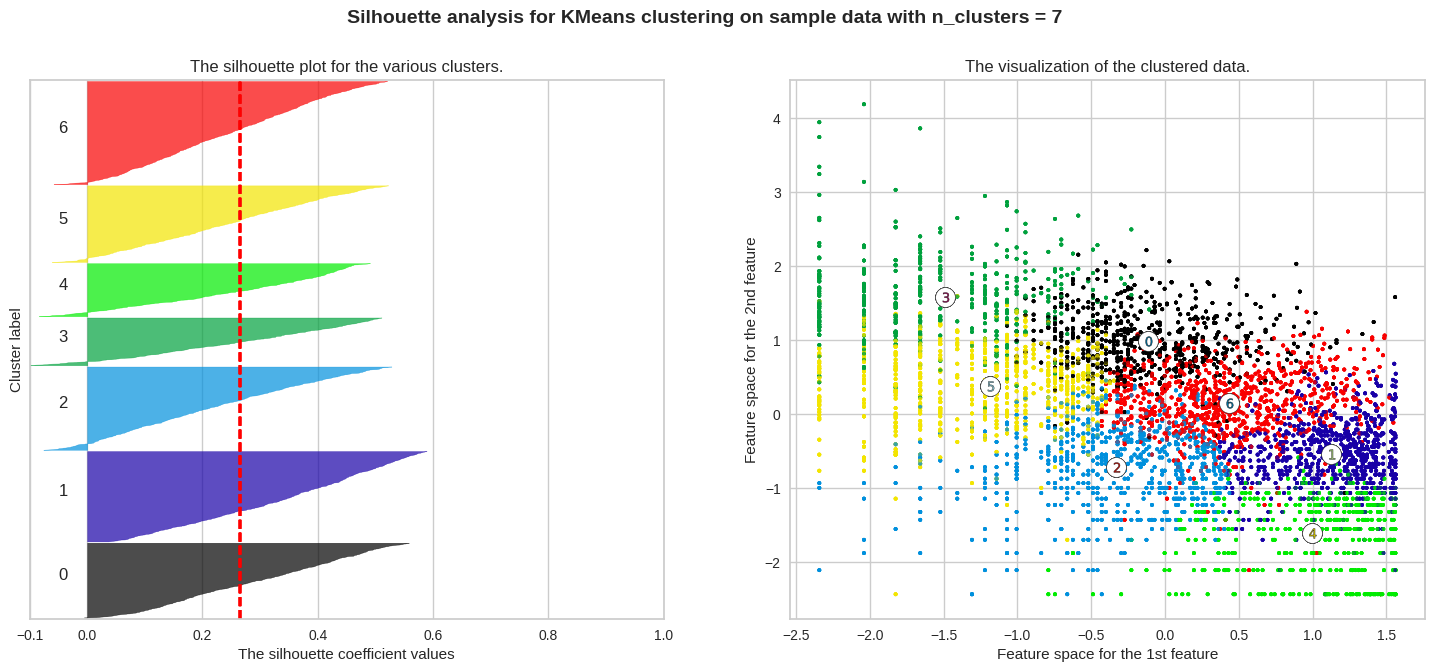

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_size_inches(18, 7)

# # The 1st subplot is the silhouette plot
# # The silhouette coefficient can range from -1, 1 but in this example all
# # lie within [-0.1, 1]
# ax1.set_xlim([-0.1, 1])
# # The (n_clusters+1)*10 is for inserting blank space between silhouette
# # plots of individual clusters, to demarcate them clearly.
# ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# # Initialize the clusterer with n_clusters value and a random generator
# # seed of 10 for reproducibility.
# clusterer = KMeans(n_clusters=n_clusters, random_state=10)
# cluster_labels = clusterer.fit_predict(X)

# # The silhouette_score gives the average value for all the samples.
# # This gives a perspective into the density and separation of the formed
# # clusters
# silhouette_avg = silhouette_score(X, cluster_labels)
# print(
#         "For n_clusters =",
#         n_clusters,
#         "The average silhouette_score is :",
#         silhouette_avg,
#     )

# y_lower = 10
# for i in range(n_clusters):
# # Aggregate the silhouette scores for samples belonging to
# # cluster i, and sort them
#     ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

#     ith_cluster_silhouette_values.sort()

#     size_cluster_i = ith_cluster_silhouette_values.shape[0]
#     y_upper = y_lower + size_cluster_i

#     color = cm.nipy_spectral(float(i) / n_clusters)
#     ax1.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )

#     # Label the silhouette plots with their cluster numbers at the middle
#     ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#     # Compute the new y_lower for next plot
#     y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("The silhouette plot for the various clusters.")
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     # Convert X to a NumPy array if it is a DataFrame
#     if isinstance(X, pd.DataFrame):
#         X_array = X.values
#     else:
#         X_array = X
#     ax2.scatter(
#         X_array[:, 0], X_array[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
#     )

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(
#         centers[:, 0],
#         centers[:, 1],
#         marker="o",
#         c="white",
#         alpha=1,
#         s=200,
#         edgecolor="k",
#     )

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(
#         "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
#         % n_clusters,
#         fontsize=14,
#         fontweight="bold",
#     )

# plt.show()